# Import

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# Dataset

In [37]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Generator

In [43]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 128, 7, 1, 0, bias=False), # 100 -> 128 채널, 출력 크기: (7, 7)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 출력 크기: (14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),    # 출력 크기: (28, 28)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),   # 출력 크기: (14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # 출력 크기: (7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),# 출력 크기: (4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # 출력 크기: (1, 1)
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Loss Function and Optimizer

In [40]:
import torch.optim as optim

netG = Generator()
netD = Discriminator()

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


# Train

In [45]:
import numpy as np
import matplotlib.pyplot as plt

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG.to(device)
netD.to(device)

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        # 판별자 학습
        netD.zero_grad()
        real_data, _ = data
        real_data = real_data.to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        output = netD(real_data)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(0)

        output = netD(fake_data.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        D_G_z1 = output.mean().item()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        # 생성자 학습
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_data)
        lossG = criterion(output, label)
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(trainloader)}] Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

# Visualization

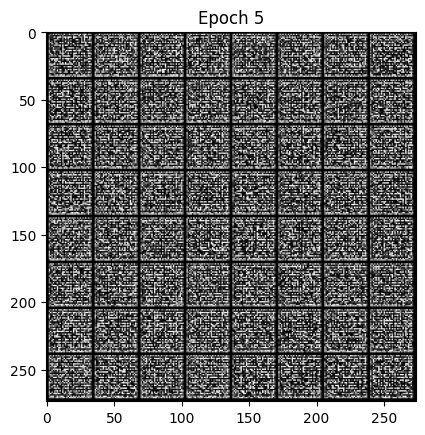

In [ ]:
import matplotlib.pyplot as plt

def show_generated_images(epoch):
    noise = torch.randn(64, 100, 1, 1, device=device)
    with torch.no_grad():
        fake_images = netG(noise).detach().cpu()
    grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f'Epoch {epoch+1}')
    plt.show()

show_generated_images(num_epochs - 1)
